<a href="https://colab.research.google.com/github/akbism/COVID-QA/blob/main/QuestionClassification/2_COVID_Question_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is for prediction of the question type of any question. 

#Setting up the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/LJMU/covidqa/biobert-pytorch
!pip install transformers==3.0.0

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch
     |████████████████████████████████| 754 kB 5.3 MB/s 
     |████████████████████████████████| 3.0 MB 48.9 MB/s 
     |████████████████████████████████| 895 kB 73.1 MB/s 
     |████████████████████████████████| 1.2 MB 62.9 MB/s 


#Setting the parameters for prediction of the question type.

In [ ]:
class Args:
    model_type = 'bert'
    model_name_or_path = 'bert-base-cased' #'dmis-lab/biobert-base-cased-v1.1-squad'
    output_dir = './scripts/output'
    golden_file = None
    official_eval_dir = './scripts/squad_eval'
    data_dir = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/SQuAD'
    train_file = 'train-v2.0.json'
    predict_file ='dev-v2.0.json'
    
    data_dir1 = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/BioASQ/BioASQ-678b'
    train_file1 = 'BioASQ-train-factoid-6_8b-full-annotated.json'
    predict_file1 ='BioASQ-train-factoid-7b-full-annotated.json'
    
    data_dir2 = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA'
    predict_file2 ='COVID-QA-Modified.json'

    config_name =None
    tokenizer_name =""
    cache_dir =None
    version_2_with_negative =True
    null_score_diff_threshold =0
    max_seq_length =384
    doc_stride =128
    max_query_length =64
    do_train = True
    do_eval = True
    evaluate_during_training = False
    do_lower_case =True
    per_gpu_train_batch_size=12
    per_gpu_eval_batch_size=12
    learning_rate=8e-6
    gradient_accumulation_steps=1
    weight_decay=0
    adam_epsilon =1e-8
    max_grad_norm = 1.0
    num_train_epochs = 3.0
    max_steps =-1
    warmup_steps = 0 
    n_best_size = 20
    max_answer_length = 30 
    verbose_logging= False
    lang_id = 0
    logging_steps=200
    save_steps=200
    eval_all_checkpoints = True
    no_cuda = False 
    overwrite_output_dir = True
    overwrite_cache = False
    seed = 0
    local_rank = -1
    fp16 = False
    fp16_opt_level= "O1"
    server_ip=""
    server_port=""
    threads=1

args=Args()

In [ ]:
# coding=utf-8
""" Finetuning the library models for question-answering on SQuAD (DistilBERT, Bert, XLM, XLNet)."""
import argparse
import glob
import logging
import os
import random
import timeit
import json
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

from transformers import (
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    squad_convert_examples_to_features,
)
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import json
from pathlib import Path
import os

### Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained("question-classification/model/epoch2")
model.to(device)

#Defining data extraction and prediction functions

In [ ]:
def read_squad(path, is_training=True):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    ids = []
    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                id = qa['id']

                is_impossible = qa.get("is_impossible", False)
                if not is_impossible:
                    if is_training:
                        answer = qa["answers"][0]
                        answer_text = answer["text"]
                        start_position_character = answer["answer_start"]
                    else:
                        answers = qa["answers"]
                # for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)
                ids.append(id)

    return ids, contexts, questions, answers


#### Prediction Function
label_dict={'DESC': 0, 'ENTY': 1, 'ABBR': 2, 'HUM': 3, 'NUM': 4, 'LOC': 5}
try:
  tokenizer
except:
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
else:
  print('tokenizer found')

def predict(test_question_series, model= model, batch_size = 3, label_dict=label_dict, tokenizer=tokenizer):

    label_dict=  {v: k for k, v in label_dict.items()}

    encoded_data_test = tokenizer.batch_encode_plus(
      test_question_series.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      pad_to_max_length=True, 
      max_length=256, 
      return_tensors='pt'
    )
    encoded_data_test=encoded_data_test.to(device)
    input_ids_test = encoded_data_test['input_ids']
    attention_masks_test = encoded_data_test['attention_mask']
    dataset_test = TensorDataset(input_ids_test, attention_masks_test)
    dataloader_test = DataLoader(dataset_test, 
                                  sampler=SequentialSampler(dataset_test), 
                                  batch_size=batch_size)
    model.eval()
    predictions = []   
    for batch in dataloader_test:      
        batch = tuple(b.to(device) for b in batch)        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1]
                 }
        with torch.no_grad():        
            outputs = model(**inputs)    
        # import pdb
        # pdb.set_trace()       
        # logits = outputs['logits']
        # logits = logits.detach().cpu().numpy()
        logits = outputs[0].numpy()
        predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    preds_flat = np.argmax(predictions, axis=1).flatten()
    preds_final = np.vectorize(label_dict.get)(preds_flat)
    return preds_final

Some weights of the model checkpoint at question-classification/model/epoch2 were not used when initializing BertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

# Prediction fo question types for SQuAD

In [ ]:
##### SQuAD
import pandas as pd
path= os.path. join(args.data_dir, args.train_file)
train_ids,train_contexts, train_questions, train_answers = read_squad(path)
path= os.path. join(args.data_dir, args.predict_file)
val_ids,val_contexts, val_questions, val_answers = read_squad(path)


val_qtype=predict(pd.Series(val_questions))
train_qtype=predict(pd.Series(train_questions))

with open('SQuAD_Q_Types_Val.pkl', 'wb') as fid:
     pickle.dump(val_qtype, fid)
with open('SQuAD_Q_Types_train.pkl', 'wb') as fid:
     pickle.dump(train_qtype, fid)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


# Prediction fo question types for BioASQ

In [ ]:
##### BioASQ Question Type
path= os.path. join(args.data_dir1, args.train_file1)
train_ids, train_contexts, train_questions, train_answers = read_squad(path)
path= os.path. join(args.data_dir1, args.predict_file1)
val_ids, val_contexts, val_questions, val_answers = read_squad(path)


val_qtype=predict(pd.Series(val_questions))
with open('BioASQ_Q_Types_Val.pkl', 'wb') as fid:
     pickle.dump(val_qtype, fid)


train_qtype=predict(pd.Series(train_questions))
with open('BioASQ_Q_Types_train.pkl', 'wb') as fid:
     pickle.dump(train_qtype, fid)

# Prediction fo question types for COVID-QA

In [ ]:
##### COVID-QA Qustion Type
path= os.path. join(args.data_dir2, args.predict_file2)
val_ids, val_contexts, val_questions, val_answers = read_squad(path)
val_ids = [str(x) for x in val_ids]
val_qtype=predict(pd.Series(val_questions))
covid_qtype = pd.DataFrame(zip(val_ids,val_qtype), columns = ['id', 'question_type'])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [ ]:
covid_qtype = pd.DataFrame(zip(val_ids,val_qtype), columns = ['id', 'question_type'])

In [ ]:
val_atype=predict(pd.Series([x['text'] for x in val_answers]))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [ ]:
import pickle 
with open('COVID-QA_Q_Types_Val.pkl', 'wb') as fid:
     pickle.dump(covid_qtype, fid)

# EDA and Visualization of Question types of the three datasets

([<matplotlib.axis.XTick at 0x7f4ac5dea310>,
 [Text(0, 0, 'ABBR'),
  Text(0, 0, 'DESC'),
  Text(0, 0, 'ENTY'),
  Text(0, 0, 'HUM'),
  Text(0, 0, 'LOC'),
  Text(0, 0, 'NUM')])

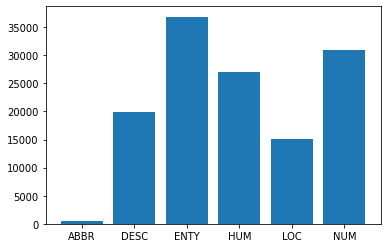

In [ ]:
import pickle
from sortedcontainers import SortedList, SortedSet, SortedDict
# Read the data from the file
with open('SQuAD_Q_Types_train.pkl', 'rb') as fid:
     train_qtype = pickle.load(fid)
from collections import Counter
train_qtype_summary = dict(SortedDict(Counter(train_qtype)))

import matplotlib.pyplot as plt
plt.bar(range(len(train_qtype_summary)), list(train_qtype_summary.values()), align='center')
plt.xticks(range(len(train_qtype_summary)), list(train_qtype_summary.keys()))


([<matplotlib.axis.XTick at 0x7fade7c77b50>,
 [Text(0, 0, 'ABBR'),
  Text(0, 0, 'DESC'),
  Text(0, 0, 'ENTY'),
  Text(0, 0, 'HUM'),
  Text(0, 0, 'LOC'),
  Text(0, 0, 'NUM')])

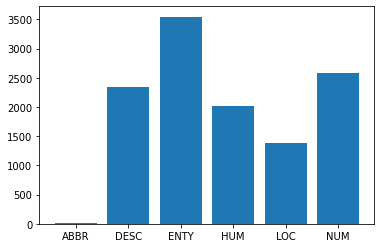

In [ ]:
import pickle
# Read the data from the file
with open('SQuAD_Q_Types_Val.pkl', 'rb') as fid:
     val_qtype = pickle.load(fid)
from collections import Counter
val_qtype_summary = dict(SortedDict(Counter(val_qtype)))

import matplotlib.pyplot as plt
plt.bar(range(len(val_qtype_summary)), list(val_qtype_summary.values()), align='center')
plt.xticks(range(len(val_qtype_summary)), list(val_qtype_summary.keys()))

([<matplotlib.axis.XTick at 0x7fade9ceb510>,
 [Text(0, 0, 'ABBR'),
  Text(0, 0, 'DESC'),
  Text(0, 0, 'ENTY'),
  Text(0, 0, 'HUM'),
  Text(0, 0, 'LOC'),
  Text(0, 0, 'NUM')])

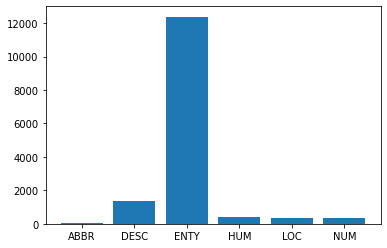

In [ ]:
import pickle
# Read the data from the file
with open('BioASQ_Q_Types_train.pkl', 'rb') as fid:
     train_qtype = pickle.load(fid)
from collections import Counter
train_qtype_summary = dict(SortedDict(Counter(train_qtype)))

import matplotlib.pyplot as plt
plt.bar(range(len(train_qtype_summary)), list(train_qtype_summary.values()), align='center')
plt.xticks(range(len(train_qtype_summary)), list(train_qtype_summary.keys()))

([<matplotlib.axis.XTick at 0x7fade904ebd0>,
 [Text(0, 0, 'ABBR'),
  Text(0, 0, 'DESC'),
  Text(0, 0, 'ENTY'),
  Text(0, 0, 'HUM'),
  Text(0, 0, 'LOC'),
  Text(0, 0, 'NUM')])

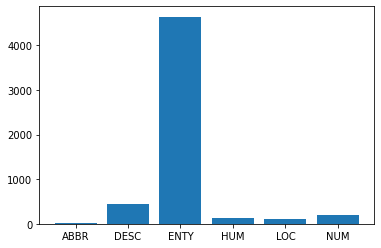

In [ ]:
import pickle
# Read the data from the file
with open('BioASQ_Q_Types_Val.pkl', 'rb') as fid:
     val_qtype = pickle.load(fid)
from collections import Counter
val_qtype_summary = dict(SortedDict(Counter(val_qtype)))

import matplotlib.pyplot as plt
plt.bar(range(len(val_qtype_summary)), list(val_qtype_summary.values()), align='center')
plt.xticks(range(len(val_qtype_summary)), list(val_qtype_summary.keys()))

In [ ]:
##### BioASQ Question Type
path= os.path. join(args.data_dir1, args.train_file1)
train_contexts, train_questions, train_answers = read_squad(path)
path= os.path. join(args.data_dir1, args.predict_file1)
val_contexts, val_questions, val_answers = read_squad(path)

In [ ]:
print(len(train_questions))
print(len(train_qtype))


14919
14919


In [ ]:
from itertools import compress
set(list(compress(train_questions, [x=='ENTY'  for x in train_qtype])))

([<matplotlib.axis.XTick at 0x7fb967c6ef90>,
 [Text(0, 0, 'ABBR'),
  Text(0, 0, 'DESC'),
  Text(0, 0, 'ENTY'),
  Text(0, 0, 'HUM'),
  Text(0, 0, 'LOC'),
  Text(0, 0, 'NUM')])

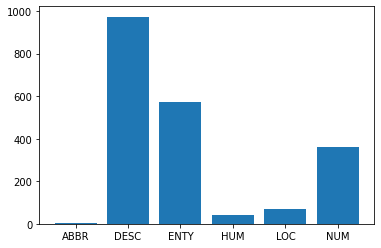

In [ ]:
import pickle
from sortedcontainers import SortedList, SortedSet, SortedDict
# Read the data from the file
with open('COVID-QA_Q_Types_Val.pkl', 'rb') as fid:
     val_qtype = pickle.load(fid)
from collections import Counter
val_qtype_summary = dict(SortedDict(Counter(val_qtype)))

import matplotlib.pyplot as plt
plt.bar(range(len(val_qtype_summary)), list(val_qtype_summary.values()), align='center')
plt.xticks(range(len(val_qtype_summary)), list(val_qtype_summary.keys()))

In [ ]:
##### COVID-QA Qustion Type
path= os.path. join(args.data_dir2, args.predict_file2)
val_contexts, val_questions, val_answers = read_squad(path)
set(list(compress(val_questions, [x=='NUM'  for x in val_qtype])))

In [ ]:
import pickle

In [ ]:
with open('SQuAD_Q_Types_train.pkl', 'rb') as fid:
     train_qtype0 = pickle.load(fid)
with open('BioASQ_Q_Types_train.pkl', 'rb') as fid:
     train_qtype1 = pickle.load(fid)
with open('COVID-QA_Q_Types_Val.pkl', 'rb') as fid:
     val_qtype2 = pickle.load(fid)



In [ ]:
train_qtype0= [(x,"SQuAD (Train)") for x in train_qtype0]
train_qtype1= [(x,"BioASQ (6B & 8B)") for x in train_qtype1]
val_qtype2= [(x,"COVID-QA") for x in val_qtype2]

import pandas as pd
import numpy as np
qtype=pd.DataFrame(train_qtype0 + train_qtype1 + val_qtype2, columns = ['Question Type', 'Dataset'])
qtype['count']=1
qtype=np.around(qtype.groupby(['Dataset','Question Type']).sum('count')/qtype.groupby(['Dataset']).sum('count'),3)*100
qtype = pd.pivot_table(qtype.reset_index(), index='Dataset', columns='Question Type', values='count', aggfunc=np.mean)#.reset_index()

In [ ]:
qtype

Question Type,ABBR,DESC,ENTY,HUM,LOC,NUM
Dataset,,,,,,
BioASQ (6B & 8B),0.2,9.2,83.0,2.9,2.2,2.5
COVID-QA,0.1,48.2,28.3,1.9,3.5,18.0
SQuAD (Train),0.4,15.3,28.3,20.7,11.5,23.8


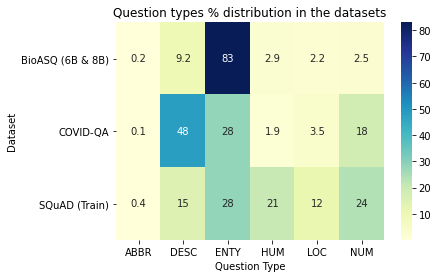

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.axes()
sns.heatmap(qtype,cmap="YlGnBu", annot=True)
ax.set_title('Question types % distribution in the datasets')
plt.show()

In [ ]:
import seaborn as sns

sea = sns.FacetGrid(qtype, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Question Type',)
